# Analyze Portfolio for IRA - 3/23/2021

In [1]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
import matplotlib as plt

%matplotlib inline

import importlib
import trading_functions as tf
importlib.reload(tf)

datafun = tf.Data()
portfun = tf.Portfolio()
retfun = tf.Returns()
selfun = tf.Selection()
factfun = tf.Factors()

import ameritrade_functions as amc
importlib.reload(amc)

plt.rcParams['figure.figsize'] = (20, 8)
print(f'Python version: {python_version()}')
print(f'Pandas version: {pd.__version__}')

Python version: 3.6.12
Pandas version: 0.22.0


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

td_ameritrade = amc.AmeritradeRest(username, password, client_id)

masked_account_number = '#---5311'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories_20210323.csv'

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but that has not been coded yet.)

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

Some issues with the current system (I plan to fix these later) is that once the module opens the browser, you will need to open it on your screen. For some reason, if it's shrunk, it does not work properly. You will notice a flashing Chrome icon on your task bar. As soon as you start the authentication process, click on the icon to open the screen. At some time in the future I will move to another mechanism like flask to avoid needed the driver and to be able to run headless.

In [3]:
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

You have authorization


## Get your account data

There are two different account functions, one that just provides high level account data, and one that also returns investment information for each account.

There is a lot of data that Ameritrade provides. I have only selected the fields that I thought were interesting. The raw data is stored in the amc class, so if you would like to get different or additional data, you can pull the raw json string and parse it.

- td_ameritrade.positions_data
- td_ameritrade.account_data

These functions will return Pandas data frames.

In [4]:
portfolios_list = td_ameritrade.parse_portfolios_list()
display(portfolios_list.sample(5))
account_data = td_ameritrade.parse_accounts()
display(account_data)
datafun.save_port_data(portfolios_list, portfolio_file_name)

,account,assetType,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,cusip,description,longQuantity,maintenanceRequirement,marketValue,previousSessionLongQuantity,settledLongQuantity,settledShortQuantity,shortQuantity,symbol,type
32,#---5311,EQUITY,77.27429,0.0,33.18,1.63,808524607,0,21.0,2074.59,2074.59,21.0,21.0,0.0,0.0,SCHA,0
35,#---5311,EQUITY,0.10570,0.0,-198.00,-5.59,Q3860H107,0,20000.0,0.00,3342.00,20000.0,20000.0,0.0,0.0,FGPHF,0
12,#---9216,EQUITY,123.01000,0.0,6.81,1.66,92206C649,0,3.0,125.11,417.03,3.0,3.0,0.0,0.0,VTWV,0
30,#---5311,EQUITY,232.60143,0.0,20.58,1.10,922908595,0,7.0,1887.62,1887.62,7.0,7.0,0.0,0.0,VBK,0
27,#---5311,EQUITY,61.33634,0.0,63.14,1.05,808524508,0,82.0,6074.56,6074.56,82.0,82.0,0.0,0.0,SCHM,0


,initialBalances_cashBalance,initialBalances_totalCash,initialBalances_equity,initialBalances_moneyMarketFund,currentBalances_cashBalance,currentBalances_equity,currentBalances_moneyMarketFund,current_return
accountId,,,,,,,,
#---2021,0.00,0.0,9348.05,82.59,0.00,9445.99,95.17,0.010423
#---5311,10.73,0.0,119436.93,6304.69,170.33,120396.42,6315.42,0.008001
#---9216,0.00,0.0,5343.31,52.65,0.00,5348.62,54.54,0.000993


## Lets narrow it down to one account

Here you can get the data for a specific account. The functions will work with the full data set, but I imagine each account would be treated differently when it comes to managing the investments.

In [5]:
portfolios_list = datafun.read_port_data(portfolio_file_name)
account_portfolio_df = datafun.get_account_portfolio_data(portfolios_list, masked_account_number)
acct_port_market_df = portfun.get_market_values(account_portfolio_df)
display(acct_port_market_df)

,marketValue
symbol,
APHA,1761.00
FGPHF,3342.00
FNCL,3302.43
FSTA,918.28
HBORF,1860.00
MMDA1,6315.36
SCHA,2074.59
SCHE,3795.60
SCHF,8717.94


## Total Portfolio and Equity Values

In [6]:
total_portfolio_value = portfun.get_account_value(acct_port_market_df).round(2)
display(f'Account {masked_account_number} total value:  {total_portfolio_value}')

equity_investments_df = portfun.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
port_equi_values = portfun.get_market_values(equity_investments_df)
total_equity_value = portfun.get_account_value(port_equi_values).round(2)
display(f'Account {masked_account_number} equity value: {total_equity_value}')

symbols = portfun.get_investment_symbols(port_equi_values)
port_weights_equity = portfun.get_portfolio_weights(port_equi_values)
display(port_weights_equity*100)

'Account #---5311 total value:  125428.03'

'Account #---5311 equity value: 119112.67'

,weight
symbol,
APHA,1.478432
FGPHF,2.805747
FNCL,2.772526
FSTA,0.770934
HBORF,1.561547
SCHA,1.741704
SCHE,3.186563
SCHF,7.319070
SCHM,5.099844


## Add additional Symbols to investigate

In [7]:
symbols_of_interest = { symbol : 0.0 for symbol in['AAPL', 'MSFT', 'GOOG', 'TSLA', 'DKNG', 'MGM', 'PDYPF']}
interesting_port_equi_values = pd.DataFrame.from_dict(symbols_of_interest, orient='index')
interesting_port_equi_values.index.name='symbol'
interesting_port_equi_values.columns = ['marketValue']
new_port_equi_values = port_equi_values.append(interesting_port_equi_values)
display(portfun.get_portfolio_weights(new_port_equi_values))

,weight
symbol,
AAPL,0.000000
APHA,0.014784
DKNG,0.000000
FGPHF,0.028057
FNCL,0.027725
FSTA,0.007709
GOOG,0.000000
HBORF,0.015615
MGM,0.000000


# Price History data

One you have a set of investments you want to work with, you will need to pull some historical data for them.

Eventually I plan to import the data into zipline, since they have an awesome set of analysis tools. But for now I'm using some functions I built to play with the data. 

### Skip if you alrady have histories

Unless you want to update them.

1 Year of daily fundamentatls data

In [332]:
number_of_years = 5
portfolio_price_histories = td_ameritrade.get_price_histories(new_port_equi_values.index, datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
datafun.save_price_histories(portfolio_price_histories, price_histories_file_name)

## Read saved data

In [8]:
portfolio_price_histories = datafun.read_price_histories(price_histories_file_name)
display(portfolio_price_histories.tail(5))

,close,high,low,open,volume,ticker,date
28568,235.28,236.8000,231.88,236.59,17160849,MSFT,2021-03-29
28569,51.59,51.6400,51.58,51.64,1202917,VTIP,2021-03-29
28570,51.61,51.8081,51.37,51.56,12617048,VWO,2021-03-29
28571,205.50,206.3600,204.24,205.59,3799120,VTI,2021-03-29
28572,218.01,225.5000,216.00,216.00,1525,PDYPF,2021-03-29


# Analysis tools

Once you have the historical data (currently pulling 1 year from today), you can start to evaluate the stocks using different functions.

In [9]:
current_weights = portfun.get_portfolio_weights(new_port_equi_values)
port_close = datafun.get_close_values(portfolio_price_histories)
display(port_close.tail(2))
port_returns = retfun.compute_returns(port_close)
display(port_returns.tail(2))

ticker,AAPL,APHA,DKNG,FGPHF,FNCL,FSTA,GOOG,HBORF,MGM,MSFT,...,TSLA,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,,,,,
2021-03-26,121.21,17.33,63.60,0.1834,49.46,41.74,2035.55,1.880,37.68,236.48,...,618.71,272.60,166.46,63.28,206.47,51.64,51.90,77.70,176.37,13.45
2021-03-29,121.21,17.01,58.25,0.1770,48.91,42.08,2055.95,1.885,36.86,235.28,...,611.50,266.34,163.31,63.05,205.50,51.59,51.61,77.32,172.47,12.94


ticker,AAPL,APHA,DKNG,FGPHF,FNCL,FSTA,GOOG,HBORF,MGM,MSFT,...,TSLA,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,,,,,
2021-03-26,0.005141,-0.034002,-0.034315,-0.044792,0.016232,0.017057,-0.004309,0.008936,-0.007376,0.017819,...,-0.033854,0.015951,0.019663,0.013291,0.016343,0.000775,0.024882,0.000257,0.015196,-0.008843
2021-03-29,0.000000,-0.018465,-0.084119,-0.034896,-0.011120,0.008146,0.010022,0.002660,-0.021762,-0.005074,...,-0.011653,-0.022964,-0.018923,-0.003635,-0.004698,-0.000968,-0.005588,-0.004891,-0.022113,-0.037918


## PCA to compute portfolio variance

In [10]:
num_factor_exposures = 20

C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AAPL,0.008453,0.036293,-0.083732,0.189026,-0.130608,-0.005809,0.002598,-0.083435,0.332414,0.007756,-0.479566,0.451392,0.597824,0.132768,-0.053709,0.047915,-0.043813,-0.019584,-0.050453,0.003145
APHA,0.066870,0.125800,-0.472012,-0.280525,-0.052336,0.820687,-0.013191,-0.015431,-0.017351,-0.030096,-0.010115,0.000889,0.011063,-0.007480,-0.001128,-0.002877,0.000212,-0.004564,-0.003020,0.001806
DKNG,-0.001102,0.023033,-0.034677,0.003747,-0.066930,0.000219,-0.032440,-0.134498,-0.211940,0.961192,-0.037089,-0.006100,0.035886,-0.006484,-0.041365,0.015619,0.020983,-0.007272,-0.020649,-0.005650
FGPHF,0.894207,-0.446455,-0.007336,0.023968,-0.015624,-0.001024,-0.000363,0.006173,-0.000442,0.010851,-0.000595,-0.001344,0.004559,-0.000873,0.000059,-0.002872,0.001311,0.002332,-0.000021,0.000299
FNCL,0.013898,0.035632,-0.095411,0.165961,-0.105164,-0.000619,0.157606,0.003050,0.035947,-0.006448,0.332475,0.194543,-0.071189,0.120547,-0.394685,0.577215,0.297632,-0.173875,0.320903,0.001169


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2016-03-30,-0.002345,0.005719,-0.003155,0.007355,-0.005837,0.003916,0.020377,-0.002660,0.014705,0.000815,-0.008310,-0.007110,0.011235,0.002840,-0.005654,0.001989,-0.000997,0.000153,0.000498,0.001262
2016-03-31,0.021825,0.052567,-0.015684,-0.019456,-0.003439,0.050867,-0.009174,0.003487,-0.011010,-0.004819,0.001993,0.003958,-0.002332,-0.008056,0.010426,-0.001798,0.005736,-0.003365,0.001243,0.001463
2016-04-01,0.006567,0.024760,0.001821,0.025631,-0.014831,-0.013553,-0.017684,0.006303,-0.011776,-0.005470,-0.008329,0.009061,-0.003620,-0.002060,-0.003217,-0.005205,0.016683,0.001237,0.003601,0.004772
2016-04-04,0.030442,0.069320,0.027487,-0.012467,0.004852,-0.000185,-0.045739,0.001218,-0.000683,-0.003434,-0.007216,0.011353,0.004202,-0.001120,-0.009581,0.002585,-0.009009,-0.000108,0.001717,-0.000115
2016-04-05,-0.006776,-0.006028,0.029166,-0.019491,0.018136,-0.019894,-0.048612,0.004436,-0.016736,-0.002914,0.000095,0.012489,-0.006555,0.002783,0.001609,-0.003769,0.004641,-0.002640,0.000127,0.001106


ticker,AAPL,APHA,DKNG,FGPHF,FNCL,FSTA,GOOG,HBORF,MGM,MSFT,...,TSLA,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,4.847122e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
APHA,0.000000e+00,7.812717e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
DKNG,0.000000e+00,0.000000e+00,4.758933e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
FGPHF,0.000000e+00,0.000000e+00,0.000000e+00,5.323689e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
FNCL,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.289100e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
FSTA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.324516e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
GOOG,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.541156e-09,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
HBORF,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.176997e-11,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
MGM,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.696679e-09,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00


,0
ticker,
AAPL,4.847122e-09
APHA,7.812717e-12
DKNG,4.758933e-10
FGPHF,5.323689e-12
FNCL,1.289100e-07


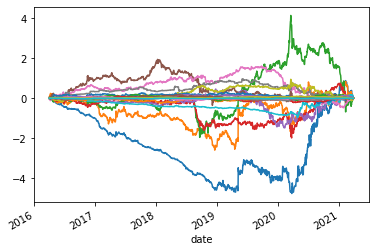

In [11]:
risk_model = tf.RiskModelPCA(port_returns, 1, num_factor_exposures)
risk_model.factor_returns_.cumsum().plot(legend=None)
display(risk_model.factor_betas_.head())
display(risk_model.factor_returns_.head())
display(risk_model.idiosyncratic_var_matrix_)
display(risk_model.idiosyncratic_var_vector_.head())

In [12]:
var_portfolio = risk_model.compute_portfolio_variance(current_weights)
print(f'portfolio variance is:  {var_portfolio:.8f}')

portfolio variance is:  0.01440659


In [13]:
factfun.sharpe_ratio(port_returns)

,Sharpe Ratio
ticker,
AAPL,1.14
APHA,1.09
DKNG,0.80
FGPHF,0.74
FNCL,0.60
FSTA,0.44
GOOG,0.90
HBORF,0.21
MGM,0.47


## Alpha Factors

In [14]:
from scipy import stats
window_length = 5

def momentum(portfolio_price_histories, days=252):
    factor_name = f'momentum_{days}_day_factor_returns'

    returns = retfun.compute_returns(datafun.get_close_values(portfolio_price_histories))
    avg_ret = returns.rolling(window=days).max()[days-1:]
    demean_ret = avg_ret.sub(avg_ret.mean(axis=1), axis=0)
    rank_ret = demean_ret.rank(axis=1)
    zscore = stats.zscore(rank_ret, ddof=1) * -1
    factor_data =  pd.DataFrame(data=zscore, index=avg_ret.index, columns=avg_ret.columns.values).stack()
    return pd.DataFrame(factor_data, columns=[factor_name])

def factor_returns(portfolio_price_histories, days=5):
    factor_name = f'mean_{days}_day_factor_returns'
    
    returns = retfun.compute_returns(datafun.get_close_values(portfolio_price_histories))
    avg_ret = returns.rolling(window=days).mean()[days-1:]
    demean_ret = avg_ret.sub(avg_ret.mean(axis=1), axis=0)
    rank_ret = demean_ret.rank(axis=1)
    zscore = stats.zscore(rank_ret, ddof=1) * -1
    factor_data =  pd.DataFrame(data=zscore, index=avg_ret.index, columns=avg_ret.columns.values).stack()
    return pd.DataFrame(factor_data, columns=[factor_name])

def factor_overnight_returns(portfolio_price_histories, days=7):
    factor_name = f'mean_{days}_day_factor_overnight_returns'
    
    close_prices = datafun.get_close_values(portfolio_price_histories)
    open_prices = datafun.get_open_values(portfolio_price_histories)
    returns = ((open_prices.shift(-1) - close_prices)  / close_prices)[:-1]
    avg_ret = returns.rolling(window=days).mean()[days-1:]
    demean_ret = avg_ret.sub(avg_ret.mean(axis=1), axis=0)
    rank_ret = demean_ret.rank(axis=1)
    zscore = stats.zscore(rank_ret, ddof=1)
    factor_data =  pd.DataFrame(data=zscore, index=avg_ret.index, columns=avg_ret.columns.values).stack()
    return pd.DataFrame(factor_data, columns=[factor_name])

In [15]:
all_factors = pd.concat(
    [momentum(portfolio_price_histories, 252),
     factor_returns(portfolio_price_histories),
     factor_overnight_returns(portfolio_price_histories)], axis=1)
all_factors.sort_index(inplace=True)

In [16]:
all_factors.head(40)

momentum_252_day_factor_returns  mean_5_day_factor_returns  \
date                                                                           
2016-04-05 AAPL                               NaN                  -0.966009   
           APHA                               NaN                  -0.896850   
           DKNG                               NaN                  -0.628150   
           FGPHF                              NaN                  -0.443079   
           FNCL                               NaN                   0.783936   
           FSTA                               NaN                  -1.299193   
           GOOG                               NaN                   0.688189   
           HBORF                              NaN                  -0.597567   
           MGM                                NaN                  -0.770294   
           MSFT                               NaN                   0.273060   
           PDYPF                              NaN                  -0.468309   
           SCHA                               NaN                   1.301930   
           SCHE                               NaN                   1.271974   
           SCHF                               NaN                   2.331978   
           SCHM                               NaN                   1.605191   
           TLRY                               NaN                  -0.589109   
           TSLA                               NaN                  -1.039421   
           VBK                                NaN                   0.605559   
           VBR                                NaN                   1.535504   
           VGK                                NaN                   1.871760   
           VTI                                NaN                   0.577235   
           VTIP                               NaN                  -1.159187   
           VWO                                NaN                   1.560458   
           VWOB                               NaN                  -0.283996   
           VXF                                NaN                   0.841302   
           WKHS                               NaN                  -1.177944   
2016-04-06 AAPL                               NaN                  -0.966009   
           APHA                               NaN                  -0.896850   
           DKNG                               NaN                  -0.072255   
           FGPHF                              NaN                   0.024055   
           FNCL                               NaN                   1.063436   
           FSTA                               NaN                  -1.156092   
           GOOG                               NaN                   0.940763   
           HBORF                              NaN                  -0.092637   
           MGM                                NaN                  -0.660227   
           MSFT                               NaN                  -0.252136   
           PDYPF                              NaN                   0.023874   
           SCHA                               NaN                   0.791116   
           SCHE                               NaN                   1.713274   
           SCHF                               NaN                   2.331978   

                  mean_7_day_factor_overnight_returns  
date                                                   
2016-04-05 AAPL                                   NaN  
           APHA                                   NaN  
           DKNG                                   NaN  
           FGPHF                                  NaN  
           FNCL                                   NaN  
           FSTA                                   NaN  
           GOOG                                   NaN  
           HBORF                                  NaN  
           MGM                                    NaN  
           MSFT                          

In [17]:
import alphalens as al
importlib.reload(al)

print(al.__version__)

assets = all_factors.index.levels[1].values.tolist()
pricing = datafun.get_close_values(portfolio_price_histories).loc[all_factors.index[0][0]:all_factors.index[-1][0]]
pricing.head()

0.4.0


ticker,AAPL,APHA,DKNG,FGPHF,FNCL,FSTA,GOOG,HBORF,MGM,MSFT,...,TSLA,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,,,,,
2016-04-05,27.4525,1.0216,20.4937,0.129,26.6232,31.75,737.80,3.8127,21.27,54.56,...,51.094,117.46,99.85,47.28,104.02,49.04,33.57,76.49,81.69,10.25
2016-04-06,27.7400,0.9961,20.4937,0.129,26.7880,31.98,745.69,3.8127,21.36,55.12,...,53.084,119.32,100.61,48.03,105.16,49.02,34.00,76.57,82.70,10.04
2016-04-07,27.1350,1.0070,20.4937,0.129,26.2737,31.71,740.28,3.8127,21.67,54.46,...,51.440,117.85,99.35,47.15,103.90,49.04,33.29,76.33,81.58,11.41
2016-04-08,27.1650,1.0873,20.4937,0.129,26.4000,31.83,739.15,3.8127,22.39,54.42,...,50.014,118.15,100.10,47.98,104.20,49.09,33.87,76.59,81.96,11.10
2016-04-11,27.2550,1.0910,20.4937,0.129,26.5200,31.61,736.10,3.8127,22.06,54.31,...,49.984,117.53,100.10,48.05,103.91,49.02,34.32,76.85,81.75,10.90


In [18]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

clean_factor_data

Dropped 19.8% entries from factor data: 19.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


{'momentum_252_day_factor_returns':                         1D    factor  factor_quantile
 date       asset                                     
 2017-03-28 AAPL   0.002225 -1.929155                1
            APHA   0.004898 -1.060529                2
            DKNG   0.000000  0.438816                4
            FGPHF  0.000000  1.117140                5
            FNCL  -0.003992 -1.421151                1
            FSTA   0.001517 -1.776249                1
            GOOG   0.012778  0.288524                3
            HBORF  0.000000  0.871668                4
            MGM    0.004417  0.987676                5
            MSFT   0.002757 -1.098060                2
            PDYPF  0.000000 -1.519827                1
            SCHA   0.004665 -1.027155                3
            SCHE   0.002471 -1.026703                3
            SCHF   0.000333 -1.493323                1
            SCHM   0.003406  1.753934                5
            TLRY   0.000000  1

In [19]:
unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

## Quantile Analysis
### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

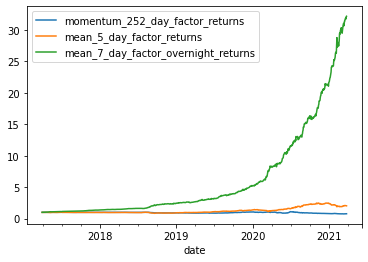

In [20]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

## Weighted portfolio returns

In [130]:
expected_port_returns = portfun.portfolio_expected_returns(port_close, current_weights)
display(expected_port_returns.tail(5))

ticker,AAPL,APHA,DKNG,FGPHF,FNCL,FSTA,GOOG,HBORF,MGM,MSFT,...,TSLA,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,,,,,
2021-03-22,0.0,-0.000440,-0.0,-0.001037,-0.000385,0.000068,-0.0,-0.000238,-0.0,0.0,...,0.0,0.000076,-0.000195,-0.000058,0.001606,0.000083,-0.000083,0.000047,-0.000034,-0.003462
2021-03-23,-0.0,-0.000502,-0.0,-0.000548,-0.000454,0.000019,0.0,-0.000242,-0.0,0.0,...,-0.0,-0.000397,-0.000587,-0.001084,-0.003411,-0.000041,-0.000399,-0.000085,-0.001401,-0.008107
2021-03-24,-0.0,-0.000544,-0.0,0.000000,0.000087,-0.000038,-0.0,-0.000163,-0.0,-0.0,...,-0.0,-0.000396,-0.000171,-0.000131,-0.002477,0.000269,-0.000573,0.000047,-0.001188,-0.010758
2021-03-25,0.0,0.000400,-0.0,0.000644,0.000470,0.000079,-0.0,-0.000388,0.0,-0.0,...,0.0,0.000199,0.000363,0.000379,0.001205,-0.000186,0.000038,-0.000041,0.000575,0.003015
2021-03-26,0.0,-0.000500,-0.0,-0.001402,0.000445,0.000129,-0.0,0.000139,-0.0,0.0,...,-0.0,0.000252,0.000351,0.000975,0.004828,0.000083,0.000596,0.000006,0.000776,-0.000996


## Volatility

In [99]:
volatility = selfun.volatility(port_returns)
display(volatility)

,volatility
ticker,
AAPL,0.023563
APHA,0.061886
DKNG,0.044982
FGPHF,0.177661
FNCL,0.020443
FSTA,0.010284
GOOG,0.020073
HBORF,0.078015
MGM,0.043845


## Portfolio optimization

In [290]:
new_weights = portfun.optimize_portfolio(port_returns, current_weights)
display(new_weights.round(4)*100)

,weight
symbol,
AAPL,0.00
APHA,0.00
DKNG,0.00
FGPHF,0.06
FNCL,0.00
FSTA,2.66
GOOG,0.00
HBORF,0.09
MGM,0.00


In [281]:
port_volume = datafun.get_values_by_date(portfolio_price_histories, 'volume')
dollar_volume_weights = portfun.generate_dollar_volume_weights(port_close, port_volume)

In [288]:
new_weights = portfun.get_optimal_weights(port_returns, dollar_volume_weights.iloc[-1], scale=1.0)
display(new_weights.round(4)*100)

display(round(new_weights * total_equity_value, 2))

,weight
ticker,
AAPL,24.91
APHA,0.43
DKNG,2.26
FGPHF,0.00
FNCL,0.03
FSTA,0.01
GOOG,6.64
HBORF,0.00
MGM,0.64


,weight
ticker,
AAPL,29872.79
APHA,518.52
DKNG,2710.24
FGPHF,0.00
FNCL,40.31
FSTA,9.75
GOOG,7966.27
HBORF,0.39
MGM,771.67


### This function broke when I moved to python 3.6 and cvxpy==1.1.x

Odd that this function calls the get_optimal_weights() function demonstrated above

In [ ]:
# all_rebalanced_weights = np.round(portfun.rebalance_portfolio(port_returns, dollar_volume_weights[1:], 2, 3), 6)
new_weights = pd.Series(all_rebalanced_weights[-1], symbols)
display(new_weights)

# Alphas

This is where zipline will come into play.

In [45]:
import trading_functions as tf
importlib.reload(tf)

factorfun = tf.Factors()

In [52]:
factors = factorfun.factor_return_mean(port_returns)
factors = factors.merge(factorfun.factor_return_median(port_returns), how='outer', left_index=True, right_index=True)
display(factors)

,factor_mean,factor_median
date,,
2020-02-20,0.005139,0.001086
2020-02-21,-0.011263,-0.009580
2020-02-24,-0.044004,-0.032904
2020-02-25,-0.019834,-0.022959
2020-02-26,-0.001199,-0.005525
...,...,...
2021-02-12,-0.002518,0.003813
2021-02-16,0.020353,-0.001783
2021-02-17,-0.019715,-0.005519


# Alphalens

In [32]:
import alphalens as al 

C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\empyrical\utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


In [ ]:
factor_names = df.columns
print(f"The factor names are {factor_names}")
factor_data = {}
for factor_name in factor_names:
    print("Formatting factor data for: " + factor_name)
    # get clean factor and forward returns for each factor
    factor_data[factor_name] = al.utils.get_clean_factor_and_forward_returns(
        factor=df[factor_name],
        prices=pricing,
        periods=[1])

## Stopped here

From this point further more work needs to be done.

In [35]:
portfolio_price_histories = datafun.read_price_histories(price_histories_file_name)
close = datafun.get_close_values(portfolio_price_histories)
close = datafun.resample_prices(close, freq='M').dropna()
symbols = portfun.get_investment_symbols(close)
returns = retfun.compute_log_returns(close).dropna()
display(selfun.get_top_n(returns, 5))
display(selfun.get_top_n(-1*returns, 5))

ticker,FGPHF,FNCL,FSTA,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,
2020-02-29,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,1
2020-03-31,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0
2020-04-30,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1
2020-05-31,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0
2020-06-30,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1
2020-07-31,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0
2020-08-31,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1
2020-09-30,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2020-10-31,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0


ticker,FGPHF,FNCL,FSTA,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,
2020-02-29,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0
2020-03-31,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1
2020-04-30,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0
2020-05-31,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2020-06-30,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0
2020-07-31,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1
2020-08-31,0,0,0,0,1,0,0,1,0,0,0,1,1,1,0,0
2020-09-30,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0
2020-10-31,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1


In [39]:
display(retfun.calculate_arithmetic_rate_of_return(port_close))
display(retfun.compute_log_returns(port_close))
display(selfun.volatility(port_close))

ticker
FGPHF    0.016779
FNCL     0.000261
FSTA     0.000316
SCHA     0.001208
SCHE     0.000914
SCHF     0.000489
SCHM     0.000827
VBK      0.001489
VBR      0.000689
VGK      0.000375
VTI      0.000867
VTIP     0.000159
VWO      0.000921
VWOB    -0.000004
VXF      0.001447
WKHS     0.012767
Name: 2021-01-29 00:00:00, dtype: float64

ticker,FGPHF,FNCL,FSTA,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,
2020-01-30,0.117783,0.011624,0.009239,0.001335,-0.009815,-0.001202,0.000331,-0.000693,0.001112,-0.000520,0.002406,0.000405,-0.013700,0.000364,0.002513,-0.063179
2020-01-31,-0.258483,-0.019449,-0.010831,-0.021573,-0.022249,-0.017598,-0.017853,-0.019003,-0.019070,-0.015550,-0.017820,0.001416,-0.017929,0.001697,-0.017246,0.151040
2020-02-03,-0.066939,0.007367,0.000266,0.011384,0.010419,0.003361,0.008048,0.010297,0.008495,0.000352,0.008768,-0.001416,0.007116,-0.004857,0.013632,-0.025238
2020-02-04,-0.007722,0.011176,0.005561,0.014316,0.024271,0.016039,0.013766,0.019056,0.010574,0.016584,0.015638,-0.001418,0.023591,0.000730,0.016937,-0.019355
2020-02-05,0.150823,0.019318,0.008153,0.013852,0.003740,0.009263,0.009671,0.004988,0.016966,0.009820,0.009799,0.000000,0.005525,-0.000852,0.004787,0.006494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,0.074108,-0.007361,0.011072,-0.000516,0.006639,0.000269,-0.004872,-0.004032,-0.002377,-0.006476,0.002833,0.000000,0.004988,0.003332,-0.002157,0.049782
2021-01-26,-0.093526,-0.007416,0.010208,-0.007246,-0.004824,0.000000,-0.008830,-0.011278,-0.007431,0.004052,-0.003630,0.000195,-0.006285,-0.000246,-0.010395,0.264137
2021-01-27,-0.020203,-0.030706,-0.016736,-0.020892,-0.027575,-0.024787,-0.027548,-0.030289,-0.020383,-0.024066,-0.024305,-0.000584,-0.025732,-0.004694,-0.025998,0.078272


,volatility
ticker,
FGPHF,0.052692
FNCL,4.714987
FSTA,2.549965
SCHA,11.966857
SCHE,3.326881
SCHF,3.385183
SCHM,8.063925
VBK,36.043415
VBR,17.990103


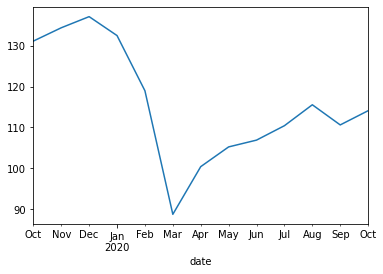

In [92]:
port_close_monthly['VBR'].plot()

In [125]:
long_df = tf.get_top_n(monthly_returns, 1)
short_df = tf.get_top_n(-1*monthly_returns, 0)

tf.portfolio_returns(long_df, short_df, lookahead_returns, 1)

ticker,AAPL,FB,GOOG,TSLA
date,,,,
2019-10-31,NaN,NaN,NaN,NaN
2019-11-30,NaN,NaN,NaN,NaN
2019-12-31,0.000000,0.000000,0.000000,0.046592
2020-01-31,0.000000,0.000000,0.000000,0.237360
2020-02-29,0.000000,0.000000,0.000000,0.441578
2020-03-31,-0.124201,0.000000,0.000000,0.000000
2020-04-30,0.000000,0.000000,0.000000,-0.242782
2020-05-31,0.000000,0.204799,0.000000,0.000000
2020-06-30,0.000000,0.000000,0.000000,0.065730


In [126]:
tf.calculate_simple_moving_average(3, monthly_close)

ticker,AAPL,FB,GOOG,TSLA
date,,,,
2019-10-31,NaN,NaN,NaN,NaN
2019-11-30,NaN,NaN,NaN,NaN
2019-12-31,67.471667,199.513333,1300.696667,70.879333
2020-01-31,72.534167,202.933333,1358.736667,93.256000
2020-02-29,73.043333,199.876667,1370.193333,115.792667
2020-03-31,69.763333,187.060000,1312.123333,122.837333
2020-04-30,68.454167,187.993333,1283.600000,131.591333
2020-05-31,72.169167,198.866667,1313.463333,142.725333
2020-06-30,81.378333,218.956667,1397.063333,179.779333


In [127]:
tf.volatility(long_df)

ticker
AAPL    0.375534
FB      0.277350
GOOG    0.375534
TSLA    0.518875
dtype: float64

In [162]:
close = tf.get_values_by_date(fundamentals_df, 'close')
tf.annualized_volatility(close)

ticker
AAPL    1.150695
FB      1.106763
GOOG    1.024521
TSLA    1.732148
dtype: float64

## From Project 2

In [129]:
fundamentals_df = td_ameritrade.read_fundamentals(test_file_name)

In [163]:
close = tf.resample_prices(tf.get_values_by_date(fundamentals_df, 'close'), freq='D').dropna()
high = tf.resample_prices(tf.get_values_by_date(fundamentals_df, 'high'), freq='D').dropna()
low = tf.resample_prices(tf.get_values_by_date(fundamentals_df, 'low'), freq='D').dropna()

In [164]:
close

ticker,AAPL,FB,GOOG,TSLA
date,,,,
2019-10-30,60.8150,188.25,1261.29,63.002
2019-10-31,62.1900,191.65,1260.11,62.984
2019-11-01,63.9550,193.62,1273.74,62.662
2019-11-04,64.3750,194.72,1291.37,63.494
2019-11-05,64.2825,194.32,1292.03,63.444
...,...,...,...,...
2020-10-26,115.0500,277.11,1590.45,420.280
2020-10-27,116.6000,283.29,1604.26,424.680
2020-10-28,111.2000,267.67,1516.62,406.020


In [133]:
lookback_days = 50
lookback_high, lookback_low = tf.get_high_lows_lookback(high, low, lookback_days)
signal = tf.get_long_short(close, lookback_high, lookback_low)
signal_5 = tf.filter_signals(signal, 5)
signal_10 = tf.filter_signals(signal, 10)
signal_20 = tf.filter_signals(signal, 20)

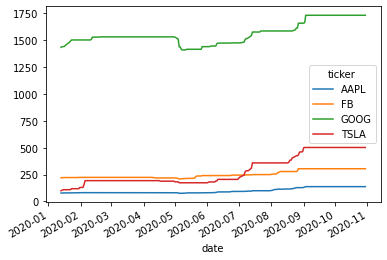

In [134]:
lookback_high.plot()

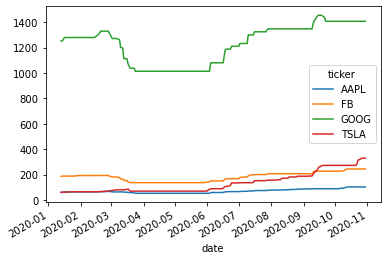

In [135]:
lookback_low.plot()

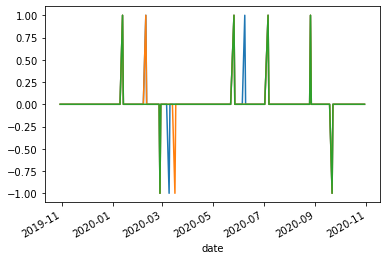

In [136]:
signal_5['GOOG'].tail(365).plot()
signal_10['GOOG'].tail(365).plot()
signal_20['GOOG'].tail(365).plot()

In [137]:
lookahead_5 = tf.get_lookahead_prices(close, 5)
lookahead_10 = tf.get_lookahead_prices(close, 10)
lookahead_20 = tf.get_lookahead_prices(close, 20)

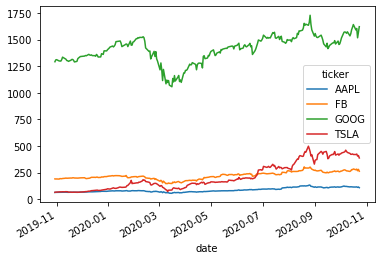

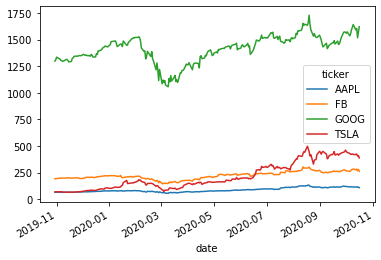

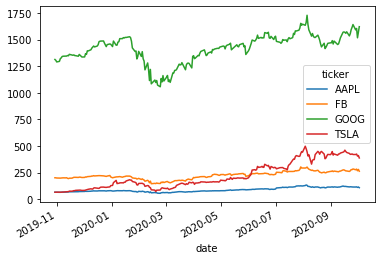

In [138]:
lookahead_5.plot()
lookahead_10.plot()
lookahead_20.plot()

In [139]:
price_return_5 = tf.get_return_lookahead(close, lookahead_5)
price_return_10 = tf.get_return_lookahead(close, lookahead_10)
price_return_20 = tf.get_return_lookahead(close, lookahead_20)

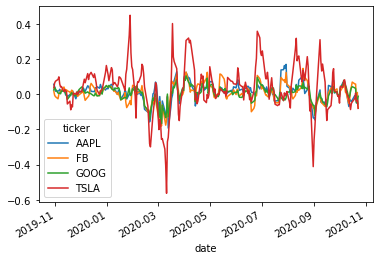

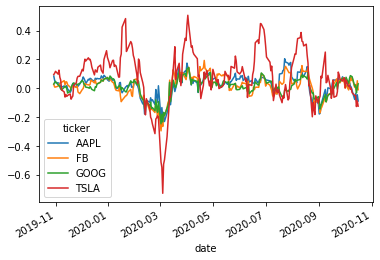

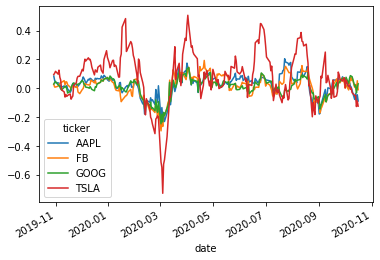

In [140]:
price_return_5.plot()
price_return_10.plot()
price_return_10.plot()

In [ ]:
signal_return_5 = tf.get_signal_return(signal_5, price_return_5)
signal_return_10 = tf.get_signal_return(signal_10, price_return_10)
signal_return_20 = tf.get_signal_return(signal_20, price_return_20)

In [ ]:
signal_return_5.plot()
signal_return_10.plot()
signal_return_20.plot()

In [ ]:
# Filter out returns that don't have a long or short signal.
long_short_signal_returns_5 = signal_return_5[signal_5 != 0].stack()
long_short_signal_returns_10 = signal_return_10[signal_10 != 0].stack()
long_short_signal_returns_20 = signal_return_20[signal_20 != 0].stack()


# Get just ticker and signal return
long_short_signal_returns_5 = long_short_signal_returns_5.reset_index().iloc[:, [1,2]]
long_short_signal_returns_5.columns = ['ticker', 'signal_return']
long_short_signal_returns_10 = long_short_signal_returns_10.reset_index().iloc[:, [1,2]]
long_short_signal_returns_10.columns = ['ticker', 'signal_return']
long_short_signal_returns_20 = long_short_signal_returns_20.reset_index().iloc[:, [1,2]]
long_short_signal_returns_20.columns = ['ticker', 'signal_return']

# View some of the data
long_short_signal_returns_5.head(10)

In [ ]:
ks_values_5, p_values_5 = tf.calculate_kstest(long_short_signal_returns_5)
ks_values_10, p_values_10 = tf.calculate_kstest(long_short_signal_returns_10)
ks_values_20, p_values_20 = tf.calculate_kstest(long_short_signal_returns_20)

print('ks_values_5')
print(ks_values_5.head(10))
print('p_values_5')
print(p_values_5.head(10))

In [ ]:
ks_threshold = 0.80
outliers_5 = tf.find_outliers(ks_values_5, p_values_5, ks_threshold)
outliers_10 = tf.find_outliers(ks_values_10, p_values_10, ks_threshold)
outliers_20 = tf.find_outliers(ks_values_20, p_values_20, ks_threshold)

outlier_tickers = outliers_5.union(outliers_10).union(outliers_20)
print('{} Outliers Found:\n{}'.format(len(outlier_tickers), ', '.join(list(outlier_tickers))))

In [ ]:
good_tickers = list(set(close.columns) - outlier_tickers)

In [ ]:
good_tickers

In [ ]:
signal_return_5.hist()
signal_return_10.hist()
signal_return_20.hist()

## Risk and Return

In [14]:
fundamentals_df = tf.read_fundamentals(test_file_name)

In [165]:
close = tf.resample_prices(amt.get_date_values(fundamentals_df, 'close'), freq='D').dropna()
returns = tf.compute_log_returns(close).dropna().T.values
cov_returns = tf.covariance_matrix(returns)
print(cov_returns)

[[0.00083212 0.00062855 0.00052454 0.00082426]
 [0.00062855 0.00079261 0.00053557 0.00067051]
 [0.00052454 0.00053557 0.00056547 0.00064061]
 [0.00082426 0.00067051 0.00064061 0.00301232]]
